## Packages

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

# Data Management
import numpy as np
import pandas as pd
import statsmodels.api as sm
import pickle
from collections import Counter

# Network Operators
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer
import networkx as nx

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Pymoo functions
from pymoo.indicators.hv import HV

# Custom modules
from stability import confidenceIntervals
from optimisation import run_optimisation, classify_optimise_repeat, lasso_mo, lasso_mo_repeat, perform_external_validation

## Data Visualisation Setup

In [2]:
sns.set_theme(style = "whitegrid", palette = "colorblind", context = "paper")

plt.rcParams.update({
    "font.size": 10,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 10,
    "figure.figsize": (6, 4),
    "axes.grid": True
})

## Data Import

First we import our two main datasets that we will use for now. `counts_df` contains the transcript counts across 271 interest genes for the 5632 cells that are of useful genotype. `genotype_scores_df` contains the FACS and proliferation scores for each unique genotype, as well as their assigned cluster.

In [3]:
counts_df = pd.read_feather("interest_counts_df.feather")
print(counts_df.shape)

genotype_scores_df = pd.read_feather("genotype_df.feather")
genotype_scores_df.head()

(5632, 272)


,unique_genotypes,facs_score,proliferation_score,custom_clusters
0,64844886-1/1/1-C-T;64844887-1/1/1-C-T;64844889...,16.508,10.304,2.0
1,64844181-1/1/1-C-T;64844183-1/1/1-C-T;64844198...,19.571,13.976,2.0
2,64844855-1/1/1-G-A,0.453,-2.231,1.0
3,64850886-1/1/1-G-A;64850904-0/0/1-G-A,-2.531,4.017,1.0
4,64857775-1/1/1-C-T;64857780-1/1/1-C-T,17.049,11.551,2.0


Re-visualisation of the labelled clusters: low FACS and low proliferation, high FACS and high proliferation, intermediate FACS and intermediate-to-high proliferation.

In [4]:
# Assuming genotype_df is already defined
X = genotype_scores_df["facs_score"]
y = genotype_scores_df["proliferation_score"]

# Add constant for intercept
X_const = sm.add_constant(X)

# Fit linear model
model = sm.OLS(y, X_const).fit()

# Generate dense x values
dense_x = np.linspace(-2.6, 21.6, 500)
dense_X_const = sm.add_constant(dense_x)

# Get predictions with confidence intervals
preds = model.get_prediction(dense_X_const).summary_frame(alpha = 0.05)

                             OLS Regression Results                            
Dep. Variable:     proliferation_score   R-squared:                       0.757
Model:                             OLS   Adj. R-squared:                  0.754
Method:                  Least Squares   F-statistic:                     270.8
Date:                 Thu, 14 Aug 2025   Prob (F-statistic):           1.89e-28
Time:                         16:32:30   Log-Likelihood:                -227.98
No. Observations:                   89   AIC:                             460.0
Df Residuals:                       87   BIC:                             464.9
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4994      0.511      2.93

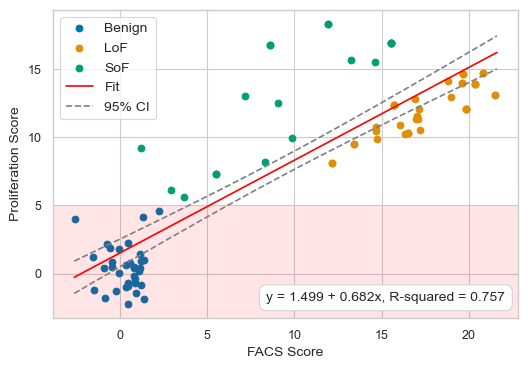

In [5]:
fig, ax = plt.subplots()

# Plot original data
cluster_1_facs = genotype_scores_df.loc[genotype_scores_df["custom_clusters"] == 1, "facs_score"]
cluster_2_facs = genotype_scores_df.loc[genotype_scores_df["custom_clusters"] == 2, "facs_score"]
cluster_3_facs = genotype_scores_df.loc[genotype_scores_df["custom_clusters"] == 3, "facs_score"]
cluster_1_proliferation = genotype_scores_df.loc[genotype_scores_df["custom_clusters"] == 1, "proliferation_score"]
cluster_2_proliferation = genotype_scores_df.loc[genotype_scores_df["custom_clusters"] == 2, "proliferation_score"]
cluster_3_proliferation = genotype_scores_df.loc[genotype_scores_df["custom_clusters"] == 3, "proliferation_score"]

ax.scatter(cluster_1_facs, cluster_1_proliferation, label = "Benign")
ax.scatter(cluster_2_facs, cluster_2_proliferation, label = "LoF")
ax.scatter(cluster_3_facs, cluster_3_proliferation, label = "SoF")

ax.set_xlabel("FACS Score")
ax.set_ylabel("Proliferation Score")

# Add regression line and confidence intervals
ax.plot(dense_x, preds["mean"], color = "red", label = "Fit")
ax.plot(dense_x, preds["mean_ci_lower"], color = "grey", linestyle = "--", label = "95% CI")
ax.plot(dense_x, preds["mean_ci_upper"], color = "grey", linestyle = "--")

# Fill background below Proliferation = 5
ax.set_ylim(ax.get_ylim()) # Lock current y-axis limits
ymin, _ = ax.get_ylim()
ax.axhspan(ymin = ymin, ymax = 5, facecolor = 'red', alpha = 0.1) 

# Add equation and R-squared
intercept = model.params["const"]
slope = model.params["facs_score"]
r_squared = model.rsquared
ax.text(8.4, -2, f"y = {intercept:.3f} + {slope:.3f}x, R-squared = {r_squared:.3f}",
        bbox = dict(facecolor = "white", edgecolor = "lightgrey", boxstyle = "round, pad = 0.5"))

ax.legend()

# Print model summary
print(model.summary())

Addition of the clusters from `genotype_scores_df` to each row of `counts_df` to be the label in the classifier:

In [6]:
label_cluster = []

for i in range(len(counts_df)):
    index = genotype_scores_df.index[genotype_scores_df["unique_genotypes"] == counts_df["GT"][i]]
    label_cluster.append(genotype_scores_df["custom_clusters"][index].values[0])

counts_df.insert(1, "label_cluster", label_cluster)

print(Counter(counts_df["label_cluster"]))

Counter({2.0: 2989, 1.0: 2062, 3.0: 581})


Create a ensembl ID to gene name conversion table:

In [7]:
# Import ensembl ID to gene name conversion data frame
id_convert_df = pd.read_csv("pathway_genes_conversion.csv")

id_convert_df.head()

,initial_alias,converted_alias,name,description,namespace
0,AKT1,ENSG00000142208,AKT1,AKT serine/threonine kinase 1 [Source:HGNC Sym...,"ENTREZGENE,GENECARDS,HGNC,UNIPROT_GN,WIKIGENE"
1,AKT2,ENSG00000105221,AKT2,AKT serine/threonine kinase 2 [Source:HGNC Sym...,"ENTREZGENE,GENECARDS,HGNC,UNIPROT_GN,WIKIGENE"
2,AKT3,ENSG00000117020,AKT3,AKT serine/threonine kinase 3 [Source:HGNC Sym...,"ENTREZGENE,GENECARDS,HGNC,UNIPROT_GN,WIKIGENE"
3,BCL2L1,ENSG00000171552,BCL2L1,BCL2 like 1 [Source:HGNC Symbol;Acc:HGNC:992],"ENTREZGENE,GENECARDS,HGNC,UNIPROT_GN,WIKIGENE"
4,CBL,ENSG00000110395,CBL,Cbl proto-oncogene [Source:HGNC Symbol;Acc:HGN...,"ENTREZGENE,GENECARDS,HGNC,UNIPROT_GN,WIKIGENE"


## Variance Thresholding

In [8]:
# -------------------------------------------
# Define Datasets and Variance Thresholding
# -------------------------------------------

labels_data = counts_df["label_cluster"]

counts_data = counts_df.copy()

# Remove all genes that show zeros across the entire set of records
# or have a variance below the defined threshold

for i in range(2, len(counts_data.columns)):
    column = counts_df.iloc[:, i]
    if all(v == 0 for v in column):
        counts_data = counts_data.drop(columns = [counts_df.columns[i]])
        
        print(f"All values in {counts_df.columns[i]} are zero. Removed {counts_df.columns[i]} from counts_data.")
    
    elif np.var(column) < 0.001:
        counts_data = counts_data.drop(columns = [counts_df.columns[i]])
        print(f"Variance of feature {counts_df.columns[i]} is below the threshold. Removed {counts_df.columns[i]} from counts_data.")


# Remove label information from counts data
counts_data = counts_data.iloc[:, 2:]

All values in ENSG00000119535 are zero. Removed ENSG00000119535 from counts_data.
Variance of feature ENSG00000162594 is below the threshold. Removed ENSG00000162594 from counts_data.
All values in ENSG00000136634 are zero. Removed ENSG00000136634 from counts_data.
Variance of feature ENSG00000142224 is below the threshold. Removed ENSG00000142224 from counts_data.
All values in ENSG00000162891 are zero. Removed ENSG00000162891 from counts_data.
Variance of feature ENSG00000162892 is below the threshold. Removed ENSG00000162892 from counts_data.
Variance of feature ENSG00000091181 is below the threshold. Removed ENSG00000091181 from counts_data.
Variance of feature ENSG00000250254 is below the threshold. Removed ENSG00000250254 from counts_data.
All values in ENSG00000109471 are zero. Removed ENSG00000109471 from counts_data.
All values in ENSG00000138684 are zero. Removed ENSG00000138684 from counts_data.
Variance of feature ENSG00000168685 is below the threshold. Removed ENSG00000168

46 of our gene features display zeros across all 5632 records, so these columns are removed.

## Mutual Information

First we define a mutual information matrix across the entire dataset.

In [9]:
# ------------------------------------
# Define a mutual information matrix
# ------------------------------------

mi_target = mutual_info_classif(counts_data, labels_data, discrete_features = False)

# Discretize gene expression data
discretizer = KBinsDiscretizer(n_bins = 10, encode = "ordinal", strategy = "uniform")
discrete_data = discretizer.fit_transform(counts_data)

# Compute pairwise MI
mi_matrix = np.zeros((counts_data.shape[1], counts_data.shape[1]))
for i in range(counts_data.shape[1]):
    for j in range(i+1, counts_data.shape[1]):
        mi = mutual_info_score(discrete_data[:, i], discrete_data[:, j])
        mi_matrix[i, j] = mi
        mi_matrix[j, i] = mi

# Rescale our matrix to be between [0, 1]
normalised_mi_matrix = mi_matrix / np.max(mi_matrix)

d:\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


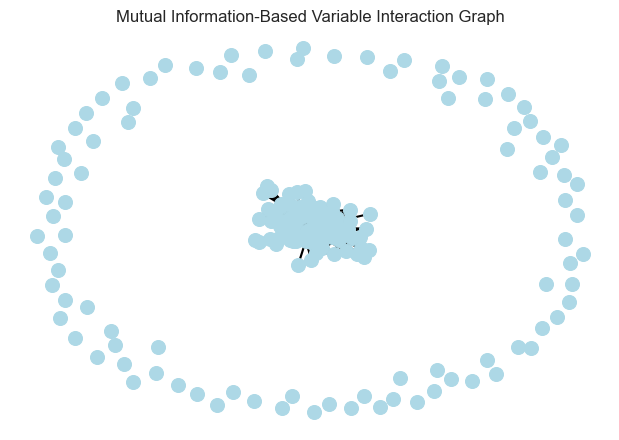

In [10]:
# --------------------------------------
# Build the mutual information network
# --------------------------------------

mi_graph = nx.Graph()

# Add nodes with MI to target
for i, gene in enumerate(counts_data.columns):
    mi_graph.add_node(gene, mi_to_target = mi_target[i])

# Add edges with MI between gene pairs
relative_threshold = 0.3 # Filter the relatively more weak interactions
for i in range(counts_data.shape[1]):
    for j in range(i+1, counts_data.shape[1]):
        if normalised_mi_matrix[i, j] > relative_threshold:
            mi_graph.add_edge(counts_data.columns[i], counts_data.columns[j], weight = normalised_mi_matrix[i, j])

# Draw graph
pos = nx.spring_layout(mi_graph, seed = 42)
edge_weights = [mi_graph[u][v]["weight"] for u, v in mi_graph.edges()]
nx.draw(mi_graph, pos, node_color = "lightblue", edge_color = "black",
        width = [w * 5 for w in edge_weights], node_size = 100, font_size = 10)
plt.title("Mutual Information-Based Variable Interaction Graph")
plt.show()

In [11]:
# ---------------------------------
# Deriving Subfunction Collection
# ---------------------------------

subfunctions = {}

for i in range(normalised_mi_matrix.shape[0]):
    connected_nodes = []
    for j in range(normalised_mi_matrix.shape[1]):
        # Define interactions as those above a normalised value of 0.3
        if normalised_mi_matrix[i, j] > 0.3:
            connected_nodes.append(j)
    
    subfunctions[f"{i}"] = connected_nodes

We now also compute the same mutual information matrix, but only for records of the intermediate label.

In [12]:
# -----------------------------------------------------
# Define a mutual information matrix for label 3 only
# -----------------------------------------------------

# Filter for records with label 3
mask = labels_data == 3
counts_data_3 = counts_data[mask]
labels_data_3 = labels_data[mask]

mi_target = mutual_info_classif(counts_data_3, labels_data_3, discrete_features = False)

# Discretize gene expression data
discretizer = KBinsDiscretizer(n_bins = 10, encode = "ordinal", strategy = "uniform")
discrete_data = discretizer.fit_transform(counts_data_3)

# Compute pairwise MI
mi_matrix = np.zeros((counts_data_3.shape[1], counts_data_3.shape[1]))
for i in range(counts_data_3.shape[1]):
    for j in range(i+1, counts_data_3.shape[1]):
        mi = mutual_info_score(discrete_data[:, i], discrete_data[:, j])
        mi_matrix[i, j] = mi
        mi_matrix[j, i] = mi

# Rescale our matrix to be between [0, 1]
normalised_mi_matrix = mi_matrix / np.max(mi_matrix)

d:\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
d:\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:278: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(
d:\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:278: UserWarning: Feature 57 is constant and will be replaced with 0.
  warnings.warn(
d:\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:278: UserWarning: Feature 85 is constant and will be replaced with 0.
  warnings.warn(
d:\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:278: UserWarning: Feature 173 is constant and will be replaced with 0.
  warnings.warn(
d:\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretizatio

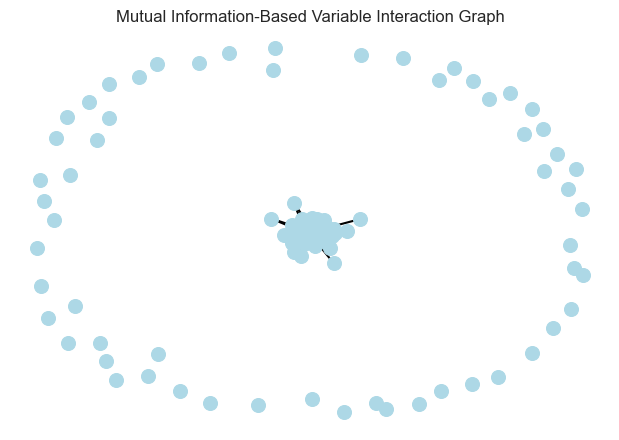

In [13]:
# -------------------------------------------------------
# Build the mutual information network for label 3 only
# -------------------------------------------------------

mi_graph = nx.Graph()

# Add nodes with MI to target
for i, gene in enumerate(counts_data.columns):
    mi_graph.add_node(gene, mi_to_target = mi_target[i])

# Add edges with MI between gene pairs
relative_threshold = 0.3 # Filter the relatively more weak interactions
for i in range(counts_data.shape[1]):
    for j in range(i+1, counts_data.shape[1]):
        if normalised_mi_matrix[i, j] > relative_threshold:
            mi_graph.add_edge(counts_data.columns[i], counts_data.columns[j], weight = normalised_mi_matrix[i, j])

# Draw graph
pos = nx.spring_layout(mi_graph, seed = 42)
edge_weights = [mi_graph[u][v]["weight"] for u, v in mi_graph.edges()]
nx.draw(mi_graph, pos, node_color = "lightblue", edge_color = "black",
        width = [w * 5 for w in edge_weights], node_size = 100, font_size = 10)
plt.title("Mutual Information-Based Variable Interaction Graph")
plt.show()

In [14]:
# --------------------------------------------------
# Deriving Subfunction Collection for label 3 only
# --------------------------------------------------

subfunctions_3 = {}

for i in range(normalised_mi_matrix.shape[0]):
    connected_nodes = []
    for j in range(normalised_mi_matrix.shape[1]):
        # Define interactions as those above a normalised value of 0.3
        if normalised_mi_matrix[i, j] > 0.3:
            connected_nodes.append(j)
    
    subfunctions_3[f"{i}"] = connected_nodes

## Constants

In [15]:
# ------------------
# Define Constants
# ------------------

pop_size = counts_data.shape[1] * 2
n_generations = 25
initial_features = 10
required_features = np.array(["ENSG00000162434"]) # JAK1
hv_reference_point = np.array([20, 0])

ind_mutation_prob = 1
var_mutation_prob = 1 / counts_data.shape[1]

label_weights = {1: 1, 2: 1, 3: 5}

## Mutual Information Testing

In [138]:
# --------------------------------------------------------------
# Perform single optimisation run utilising complete MI matrix
# --------------------------------------------------------------

counts_data_np = counts_data.values
labels_data_np = labels_data.values
feature_list = counts_data.columns.tolist()

np.random.seed(42)

# Create an empty log file 
single_run_log = "results/MI_experiment/single_run_complete_matrix_log.txt"
with open(f"{single_run_log}", "w") as f:
    f.write("Beginning optimisation...\n")  

single_run_complete_matrix_results = run_optimisation(counts_data = counts_data_np,
                                                      labels_data = labels_data_np, 
                                                      feature_list = feature_list,
                                                      label_weights = label_weights,
                                                      mutation_operator = "VIG Guided Mutation",
                                                      pop_size = pop_size,
                                                      n_generations = n_generations,
                                                      initial_pop_num_features = initial_features,
                                                      required_features = required_features,
                                                      subfunctions = subfunctions, 
                                                      ind_mutation_prob = ind_mutation_prob,
                                                      var_mutation_prob = var_mutation_prob,
                                                      n_processes = 18,
                                                      log_file = single_run_log,
                                                      random_seed = 42)

with open(f"{single_run_log}", "a") as f:
    f.write("Completed optimisation.\n")  

with open("results/MI_experiment/single_run_complete_matrix_results.pkl", "wb") as f:
    pickle.dump(single_run_complete_matrix_results, f)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      412 |      3 |             - |             -
     2 |      824 |      7 |  0.3333333333 |         ideal
     3 |     1236 |      7 |  0.0017860649 |             f
     4 |     1648 |      4 |  0.0817367476 |             f
     5 |     2060 |      5 |  0.0211617916 |         ideal
     6 |     2472 |      4 |  0.0032599339 |         ideal
     7 |     2884 |      5 |  0.0190268785 |         ideal
     8 |     3296 |      5 |  0.000000E+00 |             f
     9 |     3708 |      5 |  0.000000E+00 |             f
    10 |     4120 |      6 |  0.2000000000 |         nadir
    11 |     4532 |      6 |  0.000000E+00 |             f
    12 |     4944 |      6 |  0.000000E+00 |             f
    13 |     5356 |      7 |  0.1666666667 |         nadir
    14 |     5768 |      6 |  0.0035144081 |         ideal
    15 |     6180 |      6 |  0.000000E+00 |             f
    16 |     6592 |      6 |  0.000000E+00 |            

In [139]:
# ------------------------------------------------------------
# Perform single optimisation run utilising masked MI matrix
# ------------------------------------------------------------

counts_data_np = counts_data.values
labels_data_np = labels_data.values
feature_list = counts_data.columns.tolist()

np.random.seed(42)

# Create an empty log file 
single_run_log = "results/MI_experiment/single_run_masked_matrix_log.txt"
with open(f"{single_run_log}", "w") as f:
    f.write("Beginning optimisation...\n")  

single_run_masked_matrix_results = run_optimisation(counts_data = counts_data_np,
                                                    labels_data = labels_data_np, 
                                                    feature_list = feature_list, 
                                                    label_weights = label_weights,
                                                    mutation_operator = "VIG Guided Mutation",
                                                    pop_size = pop_size,
                                                    n_generations = n_generations,
                                                    initial_pop_num_features = initial_features,
                                                    required_features = required_features,
                                                    subfunctions = subfunctions_3, # Masked MI subfunctions
                                                    ind_mutation_prob = ind_mutation_prob,
                                                    var_mutation_prob = var_mutation_prob,
                                                    n_processes = 18,
                                                    log_file = single_run_log,
                                                    random_seed = 42)

with open(f"{single_run_log}", "a") as f:
    f.write("Completed optimisation.\n")  

with open("results/MI_experiment/single_run_masked_matrix_results.pkl", "wb") as f:
    pickle.dump(single_run_masked_matrix_results, f)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      412 |      3 |             - |             -
     2 |      824 |      5 |  0.2222222222 |         ideal
     3 |     1236 |      6 |  0.0268456182 |         ideal
     4 |     1648 |      5 |  0.1178065561 |         ideal
     5 |     2060 |      5 |  0.0121835681 |         ideal
     6 |     2472 |      6 |  0.0037983458 |         ideal
     7 |     2884 |      5 |  0.0135256038 |         ideal
     8 |     3296 |      4 |  0.0199191332 |         ideal
     9 |     3708 |      4 |  0.000000E+00 |             f
    10 |     4120 |      4 |  0.000000E+00 |             f
    11 |     4532 |      4 |  0.0087917744 |         ideal
    12 |     4944 |      4 |  0.000000E+00 |             f
    13 |     5356 |      4 |  0.0040033883 |         ideal
    14 |     5768 |      4 |  0.000000E+00 |             f
    15 |     6180 |      5 |  0.0052019197 |         ideal
    16 |     6592 |      5 |  0.000000E+00 |            

## Parameter Testing

In [140]:
# ---------------
# Label Weights
# ---------------

counts_data_np = counts_data.values
labels_data_np = labels_data.values
feature_list = counts_data.columns.tolist()

# Label weights: {1: 1, 2: 1, 3: 1}

print("Testing label weights: {1: 1, 2: 1, 3: 1}")

np.random.seed(42)

# Create an empty log file 
test_label_weights_111_log = "results/parameter_testing/test_label_weights_111_log.txt"
with open(f"{test_label_weights_111_log}", "w") as f:
    f.write("Beginning optimisation...\n")  

test_label_weights_111_results = run_optimisation(counts_data = counts_data_np,
                                                  labels_data = labels_data_np,
                                                  feature_list = feature_list, 
                                                  label_weights = {1: 1, 2: 1, 3: 1},
                                                  mutation_operator = "VIG Guided Mutation",
                                                  pop_size = pop_size,
                                                  n_generations = n_generations,
                                                  initial_pop_num_features = initial_features,
                                                  required_features = required_features,
                                                  subfunctions = subfunctions, 
                                                  ind_mutation_prob = ind_mutation_prob,
                                                  var_mutation_prob = var_mutation_prob,
                                                  n_processes = 18,
                                                  log_file = test_label_weights_111_log,
                                                  random_seed = 42)

with open("results/parameter_testing/test_label_weights_111_results.pkl", "wb") as f:
    pickle.dump(test_label_weights_111_results, f)


# Label weights: {1: 1, 2: 1, 3: 5}

print("Testing label weights: {1: 1, 2: 1, 3: 5}")

np.random.seed(42)

# Create an empty log file 
test_label_weights_115_log = "results/parameter_testing/test_label_weights_115_log.txt"
with open(f"{test_label_weights_115_log}", "w") as f:
    f.write("Beginning optimisation...\n")  

test_label_weights_115_results = run_optimisation(counts_data = counts_data_np,
                                                  labels_data = labels_data_np,
                                                  feature_list = feature_list, 
                                                  label_weights = {1: 1, 2: 1, 3: 5},
                                                  mutation_operator = "VIG Guided Mutation",
                                                  pop_size = pop_size,
                                                  n_generations = n_generations,
                                                  initial_pop_num_features = initial_features,
                                                  required_features = required_features,
                                                  subfunctions = subfunctions, 
                                                  ind_mutation_prob = ind_mutation_prob,
                                                  var_mutation_prob = var_mutation_prob,
                                                  n_processes = 18,
                                                  log_file = test_label_weights_115_log,
                                                  random_seed = 42)

with open("results/parameter_testing/test_label_weights_115_results.pkl", "wb") as f:
    pickle.dump(test_label_weights_115_results, f)

Testing label weights: {1: 1, 2: 1, 3: 1}
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      412 |      5 |             - |             -
     2 |      824 |      6 |  0.3333333333 |         ideal
     3 |     1236 |      7 |  0.0247872792 |             f
     4 |     1648 |      7 |  0.0049453786 |         ideal
     5 |     2060 |      5 |  0.0101487420 |         ideal
     6 |     2472 |      7 |  0.0070991805 |         ideal
     7 |     2884 |      8 |  0.0112715633 |         ideal
     8 |     3296 |      9 |  0.0107217518 |         ideal
     9 |     3708 |     10 |  0.0183174080 |             f
    10 |     4120 |     10 |  0.2666666667 |         nadir
    11 |     4532 |     11 |  0.0068951564 |             f
    12 |     4944 |     12 |  0.0057822567 |             f
    13 |     5356 |     12 |  0.0100654071 |         ideal
    14 |     5768 |     14 |  0.0043156033 |         ideal
    15 |     6180 |     13 |  0.1666666667 |         nadir
    16 |     6

In [142]:
# ---------------
# N Generations
# ---------------

counts_data_np = counts_data.values
labels_data_np = labels_data.values
feature_list = counts_data.columns.tolist()

# N generations: 10

print("Testing N generations: 10")

np.random.seed(42)

# Create an empty log file 
test_n_generations_10_log = "results/parameter_testing/test_n_generations_10_log.txt"
with open(f"{test_n_generations_10_log}", "w") as f:
    f.write("Beginning optimisation...\n")  

test_n_generations_10_results = run_optimisation(counts_data = counts_data_np,
                                                 labels_data = labels_data_np,
                                                 feature_list = feature_list, 
                                                 label_weights = label_weights,
                                                 mutation_operator = "VIG Guided Mutation",
                                                 pop_size = pop_size,
                                                 n_generations = 10,
                                                 initial_pop_num_features = initial_features,
                                                 required_features = required_features,
                                                 subfunctions = subfunctions, 
                                                 ind_mutation_prob = ind_mutation_prob,
                                                 var_mutation_prob = var_mutation_prob,
                                                 n_processes = 18,
                                                 log_file = test_n_generations_10_log,
                                                 random_seed = 42)

with open("results/parameter_testing/test_n_generations_10_results.pkl", "wb") as f:
    pickle.dump(test_n_generations_10_results, f)

# N generations: 25

print("Testing N generations: 25")

np.random.seed(42)

# Create an empty log file 
test_n_generations_25_log = "results/parameter_testing/test_n_generations_25_log.txt"
with open(f"{test_n_generations_25_log}", "w") as f:
    f.write("Beginning optimisation...\n")  

test_n_generations_25_results = run_optimisation(counts_data = counts_data_np,
                                                 labels_data = labels_data_np,
                                                 feature_list = feature_list, 
                                                 label_weights = label_weights,
                                                 mutation_operator = "VIG Guided Mutation",
                                                 pop_size = pop_size,
                                                 n_generations = 25,
                                                 initial_pop_num_features = initial_features,
                                                 required_features = required_features,
                                                 subfunctions = subfunctions, 
                                                 ind_mutation_prob = ind_mutation_prob,
                                                 var_mutation_prob = var_mutation_prob,
                                                 n_processes = 18,
                                                 log_file = test_n_generations_25_log,
                                                 random_seed = 42)

with open("results/parameter_testing/test_n_generations_25_results.pkl", "wb") as f:
    pickle.dump(test_n_generations_25_results, f)

# N generations: 50

print("Testing N generations: 50")

np.random.seed(42)

# Create an empty log file 
test_n_generations_50_log = "results/parameter_testing/test_n_generations_50_log.txt"
with open(f"{test_n_generations_50_log}", "w") as f:
    f.write("Beginning optimisation...\n")  

test_n_generations_50_results = run_optimisation(counts_data = counts_data_np,
                                                 labels_data = labels_data_np,
                                                 feature_list = feature_list, 
                                                 label_weights = label_weights,
                                                 mutation_operator = "VIG Guided Mutation",
                                                 pop_size = pop_size,
                                                 n_generations = 50,
                                                 initial_pop_num_features = initial_features,
                                                 required_features = required_features,
                                                 subfunctions = subfunctions, 
                                                 ind_mutation_prob = ind_mutation_prob,
                                                 var_mutation_prob = var_mutation_prob,
                                                 n_processes = 18,
                                                 log_file = test_n_generations_50_log,
                                                 random_seed = 42)

with open("results/parameter_testing/test_n_generations_50_results.pkl", "wb") as f:
    pickle.dump(test_n_generations_50_results, f)

Testing N generations: 10
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      412 |      3 |             - |             -
     2 |      824 |      7 |  0.3333333333 |         ideal
     3 |     1236 |      7 |  0.0017860649 |             f
     4 |     1648 |      4 |  0.0817367476 |             f
     5 |     2060 |      5 |  0.0211617916 |         ideal
     6 |     2472 |      4 |  0.0032599339 |         ideal
     7 |     2884 |      5 |  0.0190268785 |         ideal
     8 |     3296 |      5 |  0.000000E+00 |             f
     9 |     3708 |      5 |  0.000000E+00 |             f
    10 |     4120 |      6 |  0.2000000000 |         nadir
Testing N generations: 25
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      412 |      3 |             - |             -
     2 |      824 |      7 |  0.3333333333 |         ideal
     3 |     1236 |      7 |  0.0017860649 |             f
     4 |     1648 |      4 |  0.0817367476 |             f
    

## Optimisation Repeats

In [18]:
# ----------------------------------
# Perform repeat optimisation runs
# ----------------------------------

counts_data_np = counts_data.values
labels_data_np = labels_data.values
feature_list = counts_data.columns.tolist()

# Create an empty log file 
final_repeat_run_log = "results/final_repeat_run_log.txt"
with open(f"{final_repeat_run_log}", "w") as f:
    f.write("Beginning optimisation...\n")  

n_repeats = 20

final_repeat_run_results = classify_optimise_repeat(counts_data = counts_data_np, 
                                                    labels_data = labels_data_np, 
                                                    feature_list = feature_list,
                                                    label_weights = label_weights,
                                                    mutation_operator = "VIG Guided Mutation",
                                                    pop_size = pop_size, 
                                                    n_generations = n_generations, 
                                                    initial_pop_num_features = initial_features, 
                                                    required_features = required_features, 
                                                    subfunctions = subfunctions,
                                                    ind_mutation_prob = ind_mutation_prob,
                                                    var_mutation_prob = var_mutation_prob,
                                                    n_processes = 18,
                                                    n_repeats = n_repeats,
                                                    log_file = final_repeat_run_log,
                                                    random_seed = 42)

with open(f"{final_repeat_run_log}", "a") as f:
    f.write("Completed optimisation.\n")  

with open("results/final_repeat_run_results.pkl", "wb") as f:
    pickle.dump(final_repeat_run_results, f)

Starting Repeat 1 out of 20...
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      412 |      4 |             - |             -
     2 |      824 |      7 |  0.1666666667 |         ideal
     3 |     1236 |      6 |  0.2187038480 |         ideal
     4 |     1648 |      5 |  0.1041682381 |         ideal
     5 |     2060 |      5 |  0.0212927321 |         ideal
     6 |     2472 |      3 |  0.0171533825 |         ideal
     7 |     2884 |      4 |  0.0368367722 |         ideal
     8 |     3296 |      4 |  0.0052201366 |         ideal
     9 |     3708 |      5 |  0.0500934628 |             f
    10 |     4120 |      5 |  0.0019834451 |             f
    11 |     4532 |      5 |  0.0019834451 |             f
    12 |     4944 |      5 |  0.0027830195 |             f
    13 |     5356 |      5 |  0.0054980351 |         ideal
    14 |     5768 |      5 |  0.000000E+00 |             f
    15 |     6180 |      5 |  0.0026146727 |         ideal
    16 |     6592 |      

In [21]:
# ----------------------------------------------------------
# Perform repeat optimisation - standard mutation operator
# ----------------------------------------------------------

counts_data_np = counts_data.values
labels_data_np = labels_data.values
feature_list = counts_data.columns.tolist()

# Create an empty log file 
repeat_run_standard_mutation_operator_log = "results/repeat_run_standard_mutation_operator_log.txt"
with open(f"{repeat_run_standard_mutation_operator_log}", "w") as f:
    f.write("Beginning optimisation...\n")  

n_repeats = 20

repeat_run_standard_mutation_operator_results = classify_optimise_repeat(counts_data = counts_data_np, 
                                                                         labels_data = labels_data_np, 
                                                                         feature_list = feature_list,
                                                                         label_weights = label_weights,
                                                                         mutation_operator = "Bitflip Mutation",
                                                                         pop_size = pop_size,
                                                                         n_generations = n_generations, 
                                                                         initial_pop_num_features = initial_features, 
                                                                         required_features = required_features,
                                                                         subfunctions = subfunctions,
                                                                         ind_mutation_prob = ind_mutation_prob,
                                                                         var_mutation_prob = var_mutation_prob,
                                                                         n_processes = 18,
                                                                         n_repeats = n_repeats,
                                                                         log_file = repeat_run_standard_mutation_operator_log,
                                                                         random_seed = 42)

with open(f"{repeat_run_standard_mutation_operator_log}", "a") as f:
    f.write("Completed optimisation.\n")  

with open("results/repeat_run_standard_mutation_operator_results.pkl", "wb") as f:
    pickle.dump(repeat_run_standard_mutation_operator_results, f) 

Starting Repeat 1 out of 20...
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      412 |      4 |             - |             -
     2 |      824 |      7 |  0.1666666667 |         ideal
     3 |     1236 |      5 |  0.3151460834 |         ideal
     4 |     1648 |      5 |  0.0200071626 |             f
     5 |     2060 |      5 |  0.0636131098 |             f
     6 |     2472 |      6 |  0.0271163552 |         ideal
     7 |     2884 |      4 |  0.0031974839 |         ideal
     8 |     3296 |      5 |  0.0123924276 |         ideal
     9 |     3708 |      6 |  0.0119127527 |         ideal
    10 |     4120 |      5 |  0.2500000000 |         nadir
    11 |     4532 |      5 |  0.0287430914 |         ideal
    12 |     4944 |      5 |  0.0035504614 |             f
    13 |     5356 |      5 |  0.000000E+00 |             f
    14 |     5768 |      5 |  0.000000E+00 |             f
    15 |     6180 |      5 |  0.000000E+00 |             f
    16 |     6592 |      

## LASSO-MO

In [ ]:
# ----------------------
# Repeat Lasso-MO runs
# ----------------------

n_repeats = 20

repeat_run_lasso_mo_results = lasso_mo_repeat(X = counts_data,
                                              y = labels_data,
                                              label_weights = label_weights,
                                              n_repeats = n_repeats,
                                              initial_C = 1,
                                              decay = 0.99,
                                              random_seed = 42)

with open("results/repeat_run_lasso_mo_results.pkl", "wb") as f:
    pickle.dump(repeat_run_lasso_mo_results, f)

Starting Repeat 1 out of 20...
C = 1, number of features: 194, weighted accuracy: 0.29833390052705333.
C = 0.99, number of features: 197, weighted accuracy: 0.30840949094140896.
C = 0.9801, number of features: 197, weighted accuracy: 0.31273813110739684.
C = 0.9702989999999999, number of features: 193, weighted accuracy: 0.3040273061191779.
C = 0.96059601, number of features: 196, weighted accuracy: 0.297930734895969.
C = 0.9509900498999999, number of features: 196, weighted accuracy: 0.29049650466786936.
C = 0.9414801494009999, number of features: 193, weighted accuracy: 0.28689205872012774.
C = 0.9320653479069899, number of features: 189, weighted accuracy: 0.3082527364420921.
C = 0.92274469442792, number of features: 195, weighted accuracy: 0.3023588650024826.
C = 0.9135172474836407, number of features: 189, weighted accuracy: 0.32308500513865146.
C = 0.9043820750088043, number of features: 194, weighted accuracy: 0.31185718238983373.
C = 0.8953382542587163, number of features: 191,

## Results

In [17]:
with open("results/MI_experiment/single_run_complete_matrix_results.pkl", "rb") as f:
    single_run_complete_matrix_results = pickle.load(f)

In [18]:
with open("results/MI_experiment/single_run_masked_matrix_results.pkl", "rb") as f:
    single_run_masked_matrix_results = pickle.load(f)

In [19]:
with open("results/parameter_testing/test_label_weights_111_results.pkl", "rb") as f:
    test_label_weights_111_results = pickle.load(f)

with open("results/parameter_testing/test_label_weights_115_results.pkl", "rb") as f:
    test_label_weights_115_results = pickle.load(f)

In [20]:
with open("results/parameter_testing/test_n_generations_10_results.pkl", "rb") as f:
    test_n_generations_10_results = pickle.load(f)

with open("results/parameter_testing/test_n_generations_25_results.pkl", "rb") as f:
    test_n_generations_25_results = pickle.load(f)

with open("results/parameter_testing/test_n_generations_50_results.pkl", "rb") as f:
    test_n_generations_50_results = pickle.load(f)

In [21]:
with open("results/final_repeat_run_results.pkl", "rb") as f:
    final_repeat_run_results = pickle.load(f)

In [22]:
with open("results/repeat_run_standard_mutation_operator_results.pkl", "rb") as f:
    repeat_run_standard_mutation_operator_results = pickle.load(f)

In [23]:
with open("results/repeat_run_lasso_mo_results.pkl", "rb") as f:
    repeat_run_lasso_mo_results = pickle.load(f)

### MI Construction Comparison

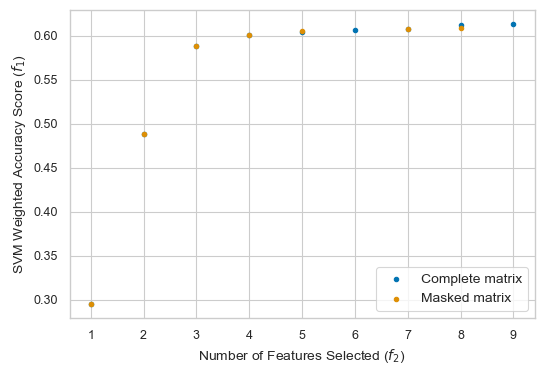

In [24]:
fig, ax = plt.subplots()

# Plot complete matrix
pareto_front_complete_matrix = single_run_complete_matrix_results["F"]
  
num_features_complete_matrix = pareto_front_complete_matrix[:, 0].tolist()
weighted_accuracy_complete_matrix = pareto_front_complete_matrix[:, 1].tolist()
weighted_accuracy_complete_matrix = [abs(acc) for acc in weighted_accuracy_complete_matrix] # Convert to positive values

ax.scatter(num_features_complete_matrix, weighted_accuracy_complete_matrix, label = "Complete matrix", s = 10)

# Plot masked matrix
pareto_front_masked_matrix = single_run_masked_matrix_results["F"]
  
num_features_masked_matrix = pareto_front_masked_matrix[:, 0].tolist()
weighted_accuracy_masked_matrix = pareto_front_masked_matrix[:, 1].tolist()
weighted_accuracy_masked_matrix = [abs(acc) for acc in weighted_accuracy_masked_matrix] # Convert to positive values

ax.scatter(num_features_masked_matrix, weighted_accuracy_masked_matrix, label = "Masked matrix", s = 10)

# Add axis labels
ax.set_xlabel(r"Number of Features Selected ($f_2$)")
ax.set_ylabel(r"SVM Weighted Accuracy Score ($f_1$)")

ax.legend(loc = "lower right", frameon = True, facecolor = "white")

### Label Weights Comparison - External Validation

In [27]:
external_validation_111 = perform_external_validation(counts_data = counts_data_np,
                                                      labels_data = labels_data_np,
                                                      label_weights = {1: 1, 2: 1, 3: 1},
                                                      results = test_label_weights_111_results)

In [28]:
external_validation_115 = perform_external_validation(counts_data = counts_data_np,
                                                      labels_data = labels_data_np,
                                                      label_weights = {1: 1, 2: 1, 3: 5},
                                                      results = test_label_weights_115_results)

C:\Users\miles\AppData\Local\Temp\ipykernel_21364\2945023451.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Benign", "LoF", "SoF"])


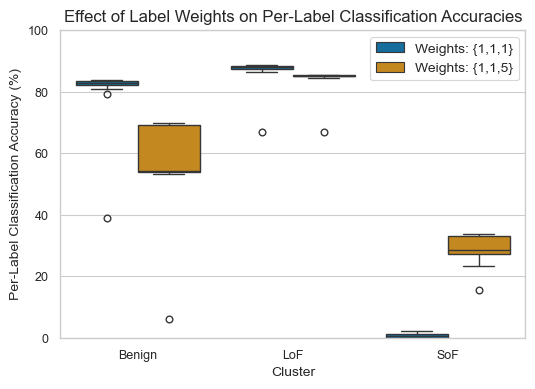

In [29]:
# Combine both datasets into a tidy format
combined_external_validation = []

for i, entry in enumerate(external_validation_111):
    for key in [1, 2, 3]:
        combined_external_validation.append({"Key": str(key), "Value": entry[key] * 100, "Dataset": "Weights: {1,1,1}"})

for i, entry in enumerate(external_validation_115):
    for key in [1, 2, 3]:
        combined_external_validation.append({"Key": str(key), "Value": entry[key] * 100, "Dataset": "Weights: {1,1,5}"})

label_weights_external_validation_df = pd.DataFrame(combined_external_validation)

# Plot using seaborn
fig, ax = plt.subplots()
sns.boxplot(x = "Key", y = "Value", hue = "Dataset", data = label_weights_external_validation_df, ax = ax)

# Adjust y-axis limits
ax.set_ylim(0, 100)

# Add labels
ax.set_title("Effect of Label Weights on Per-Label Classification Accuracies")
ax.set_xlabel("Cluster")
ax.set_ylabel("Per-Label Classification Accuracy (%)")
ax.set_xticklabels(["Benign", "LoF", "SoF"])

ax.legend(title = None)

plt.show()

In [33]:
from scipy.stats import ttest_ind

label_weights_external_validation_df['Key'] = label_weights_external_validation_df['Key'].astype(float)

# ----------------
# Benign cluster
# ----------------

# Filter rows where Key == 1.0 == Benign cluster
df_Benign = label_weights_external_validation_df[label_weights_external_validation_df["Key"] == 1.0]

# Split into two groups 
group_111 = df_Benign[df_Benign["Dataset"] == "Weights: {1,1,1}"]["Value"]
group_115 = df_Benign[df_Benign["Dataset"] == "Weights: {1,1,5}"]["Value"]

# Welch's t-test
t_stat, p_value = ttest_ind(group_111, group_115, equal_var = False)

# Print results
print(f"Cluster: Benign, T-statistic: {t_stat:.4f}, P-value: {p_value}")

# ----------------
# LoF cluster
# ----------------

# Filter rows where Key == 2.0 == LoF cluster
df_LoF = label_weights_external_validation_df[label_weights_external_validation_df["Key"] == 2.0]

# Split into two groups 
group_111 = df_LoF[df_LoF["Dataset"] == "Weights: {1,1,1}"]["Value"]
group_115 = df_LoF[df_LoF["Dataset"] == "Weights: {1,1,5}"]["Value"]

# Welch's t-test
t_stat, p_value = ttest_ind(group_111, group_115, equal_var = False)

# Print results
print(f"Cluster: LoF, T-statistic: {t_stat:.4f}, P-value: {p_value}")

# ----------------
# SoF cluster
# ----------------

# Filter rows where Key == 3.0 == SoF cluster
df_SoF = label_weights_external_validation_df[label_weights_external_validation_df["Key"] == 3.0]

# Split into two groups 
group_111 = df_SoF[df_SoF["Dataset"] == "Weights: {1,1,1}"]["Value"]
group_115 = df_SoF[df_SoF["Dataset"] == "Weights: {1,1,5}"]["Value"]

# Welch's t-test
t_stat, p_value = ttest_ind(group_111, group_115, equal_var = False)

# Print results
print(f"Cluster: SoF, T-statistic: {t_stat:.4f}, P-value: {p_value}")

Cluster: Benign, T-statistic: 3.5647, P-value: 0.0049507876432356756
Cluster: LoF, T-statistic: 1.5404, P-value: 0.14650600289145663
Cluster: SoF, T-statistic: -14.1626, P-value: 5.112612471769495e-07


### N Generations Comparison

In [34]:
print("N Generations - 10:")
print(test_n_generations_10_results["F"])

# Hypervolume calculation
test_n_generations_10_pareto_front_min = test_n_generations_10_results["F"].copy()
test_n_generations_10_hv = HV(ref_point = hv_reference_point)
test_n_generations_10_hypervolume = test_n_generations_10_hv.do(test_n_generations_10_pareto_front_min)
print(f"Hypervolume: {test_n_generations_10_hypervolume}\n")


print("N Generations - 25:")
print(test_n_generations_25_results["F"])

# Hypervolume calculation
test_n_generations_25_pareto_front_min = test_n_generations_25_results["F"].copy()
test_n_generations_25_hv = HV(ref_point = hv_reference_point)
test_n_generations_25_hypervolume = test_n_generations_25_hv.do(test_n_generations_25_pareto_front_min)
print(f"Hypervolume: {test_n_generations_25_hypervolume}\n")


print("N Generations - 50:")
print(test_n_generations_50_results["F"])

# Hypervolume calculation
test_n_generations_50_pareto_front_min = test_n_generations_50_results["F"].copy()
test_n_generations_50_hv = HV(ref_point = hv_reference_point)
test_n_generations_50_hypervolume = test_n_generations_50_hv.do(test_n_generations_50_pareto_front_min)
print(f"Hypervolume: {test_n_generations_50_hypervolume}\n")

N Generations - 10:
[[ 1.         -0.29531592]
 [ 2.         -0.48900515]
 [ 3.         -0.58898914]
 [ 4.         -0.60139853]
 [ 5.         -0.60298751]
 [ 6.         -0.60325841]]
Hypervolume: 11.023314008811962

N Generations - 25:
[[ 1.         -0.29531592]
 [ 2.         -0.48900515]
 [ 3.         -0.58898914]
 [ 4.         -0.60139853]
 [ 6.         -0.60670071]
 [ 7.         -0.60781023]
 [ 5.         -0.60472091]
 [ 9.         -0.61362833]
 [ 8.         -0.61223227]]
Hypervolume: 11.156084465224932

N Generations - 50:
[[ 1.         -0.29531592]
 [ 2.         -0.48900515]
 [ 3.         -0.58898914]
 [ 4.         -0.60139853]
 [ 6.         -0.60963077]
 [ 7.         -0.61499456]
 [ 5.         -0.60609536]
 [ 9.         -0.62122034]]
Hypervolume: 11.253847758702197



### Stability

In [35]:
# ------------------
# Final repeat run
# ------------------

# Get list of all feature counts that exist in solutions across repeat experiment pareto fronts
feature_counts = set()
for i in range(20):
    pareto_front = final_repeat_run_results[f"{i+1}"]["results"]["F"]

    feature_counts.update(pareto_front[:, 0].astype(int))

feature_counts = list(feature_counts)

# Calculate stability measures
final_repeat_run_results_stability_measures = {}

for count in feature_counts:
    # Collect all solutions with counts number of features
    solutions = []

    for i in range(20):
        index = np.where(final_repeat_run_results[f"{i+1}"]["results"]["F"][:, 0] == count)[0]

        if len(index) == 1:
            solution = final_repeat_run_results[f"{i+1}"]["results"]["X"][index].astype(int)

        solutions.append(solution)

    # Convert to a matrix in order to apply confidenceIntervals() function
    solutions_matrix = np.vstack(solutions)
    solutions_stability = confidenceIntervals(solutions_matrix)

    # Update stability measures dictionary
    final_repeat_run_results_stability_measures.update({
        f"{count}": {
            "solutions": solutions_matrix,
            "stability": solutions_stability["stability"],
            "lower CI": solutions_stability["lower"],
            "upper CI": solutions_stability["upper"]
        }
    })

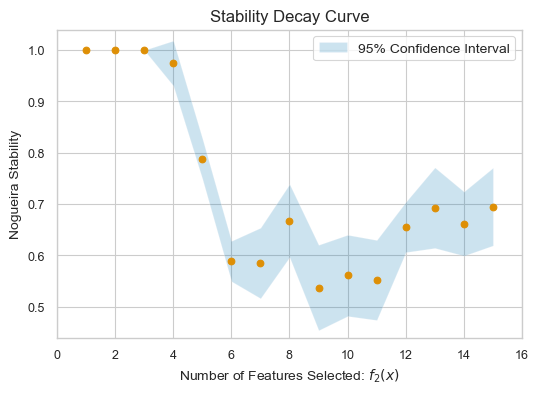

In [36]:
fig, ax = plt.subplots(figsize = (6, 4))

# VI-guided mutation operator plot

# Convert data to list format
num_features = []
stability = []
lower_CIs = []
upper_CIs = []

for key in final_repeat_run_results_stability_measures:
    num_features.append(int(key))
    stability.append(final_repeat_run_results_stability_measures[key]["stability"])
    lower_CIs.append(final_repeat_run_results_stability_measures[key]["lower CI"])
    upper_CIs.append(final_repeat_run_results_stability_measures[key]["upper CI"])

ax.fill_between(num_features, lower_CIs, upper_CIs, alpha = 0.2, label = "95% Confidence Interval")
ax.scatter(num_features, stability)
ax.set_xlim(0, 16)
ax.set_ylim(0.44, 1.04)

# Add axis labels
ax.set_title("Stability Decay Curve")
ax.set_xlabel(r"Number of Features Selected: $f_2(x)$")
ax.set_ylabel("Nogueira Stability")
ax.legend()

In [37]:
# Final repeat run stability hypothesis testing

from stability import hypothesisTestT

for i in range(1, 15):
    print(f"Hypothesis test comparing Number of Features: {i+1} to {i}")

    # Hypothesis test for stability
    print(hypothesisTestT(final_repeat_run_results_stability_measures[f"{i+1}"]["solutions"], 
                          final_repeat_run_results_stability_measures[f"{i}"]["solutions"]))

Hypothesis test comparing Number of Features: 2 to 1
{'reject': False, 'T': 0.0, 'p-value': 1.0}
Hypothesis test comparing Number of Features: 3 to 2
{'reject': False, 'T': 0.0, 'p-value': 1.0}
Hypothesis test comparing Number of Features: 4 to 3
{'reject': False, 'T': 1.139975946761295, 'p-value': 0.2542963222169836}
Hypothesis test comparing Number of Features: 5 to 4
{'reject': True, 'T': 6.190682558789707, 'p-value': 5.990423712631809e-10}
Hypothesis test comparing Number of Features: 6 to 5
{'reject': True, 'T': 7.036350427661963, 'p-value': 1.9733104039687532e-12}
Hypothesis test comparing Number of Features: 7 to 6
{'reject': False, 'T': 0.09287620051863987, 'p-value': 0.926001913242529}
Hypothesis test comparing Number of Features: 8 to 7
{'reject': False, 'T': -1.6362933686483392, 'p-value': 0.10177820330673315}
Hypothesis test comparing Number of Features: 9 to 8
{'reject': True, 'T': 2.333457939471239, 'p-value': 0.01962412339054964}
Hypothesis test comparing Number of Featu

### Occurrence Frequency

In [38]:
occurrence_frequency = np.zeros(counts_data.shape[1])
occurrence_frequency_total = 0

for i in range(20):
    pareto_solutions_i = final_repeat_run_results[f"{i+1}"]["results"]["X"]

    for solution in pareto_solutions_i:
        # Extract indices included in each solution
        included_indices = [i for i, val in enumerate(solution) if val]

        # Only consider checking for co-occurrence in solutions with multiple features
        if len(included_indices) > 1:
            for j in range(len(included_indices)):
                included_index_j = included_indices[j]

                # Increment occurring features by 1
                occurrence_frequency[included_index_j] += 1
            
            # Increment total number of solutions
            occurrence_frequency_total += 1

print(f"Total number of Pareto-optimal solutions with N features > 1: {occurrence_frequency_total}.")

Total number of Pareto-optimal solutions with N features > 1: 140.


In [39]:
# Extract list of gene names from feature list
gene_name_list = []
for i in range(len(feature_list)):
    gene_name_list.append(id_convert_df.loc[id_convert_df["converted_alias"] == feature_list[i], "initial_alias"].values[0])

# Zip lists to co-sort them, and unzip to represent the lists separately
sorted_zip = sorted(zip(occurrence_frequency, gene_name_list), reverse = True)
sorted_occurrence_frequency, sorted_gene_name_list = zip(*sorted_zip)

# Print ordered frequencies to user
for i in range(len(gene_name_list)):
    print(f"Gene: {sorted_gene_name_list[i]}, Frequency: {sorted_occurrence_frequency[i]}")

Gene: STAT1, Frequency: 140.0
Gene: JAK1, Frequency: 140.0
Gene: SOCS1, Frequency: 120.0
Gene: IRF9, Frequency: 40.0
Gene: CISH, Frequency: 39.0
Gene: JAK2, Frequency: 23.0
Gene: CDK1, Frequency: 22.0
Gene: CCND1, Frequency: 22.0
Gene: YWHAB, Frequency: 19.0
Gene: SPRY1, Frequency: 18.0
Gene: SOCS4, Frequency: 14.0
Gene: ESPL1, Frequency: 10.0
Gene: ORC1, Frequency: 7.0
Gene: CNTF, Frequency: 7.0
Gene: CDKN1A, Frequency: 7.0
Gene: CBL, Frequency: 7.0
Gene: CDKN2A, Frequency: 6.0
Gene: CCNB3, Frequency: 6.0
Gene: RAD21, Frequency: 5.0
Gene: JAK3, Frequency: 5.0
Gene: IFNL1, Frequency: 5.0
Gene: CDKN1C, Frequency: 5.0
Gene: CDC27, Frequency: 5.0
Gene: YWHAZ, Frequency: 4.0
Gene: PRLR, Frequency: 4.0
Gene: PRKDC, Frequency: 4.0
Gene: PIK3R2, Frequency: 4.0
Gene: IL3RA, Frequency: 4.0
Gene: IL12RB1, Frequency: 4.0
Gene: IL12A, Frequency: 4.0
Gene: STAT5A, Frequency: 3.0
Gene: SOCS2, Frequency: 3.0
Gene: RBL2, Frequency: 3.0
Gene: PIK3CD, Frequency: 3.0
Gene: IL23A, Frequency: 3.0
Gene: E2F

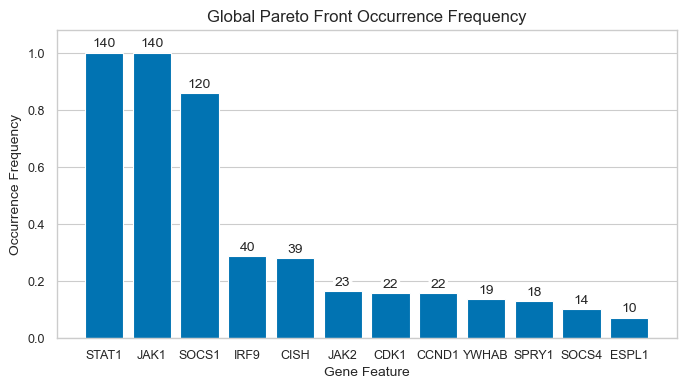

In [40]:
# Place the above top 12 results into lists
most_frequent_gene_names = []
most_frequent_occurrence_frequencies = []

for i in range(12):
    most_frequent_gene_names.append(sorted_gene_name_list[i])
    most_frequent_occurrence_frequencies.append(sorted_occurrence_frequency[i])

most_frequent_occurrence_percentages = [frequency / occurrence_frequency_total for frequency in most_frequent_occurrence_frequencies]

# Plot frequency histogram
fig, ax = plt.subplots(figsize = (8, 4))
bars = ax.bar(most_frequent_gene_names, most_frequent_occurrence_percentages)

# Add labels
ax.set_xlabel("Gene Feature")
ax.set_ylabel("Occurrence Frequency")
ax.set_title("Global Pareto Front Occurrence Frequency")

# Adjust y axis limits and remove vertical gridlines
ax.set_ylim(0, 1.08)
ax.grid(False, axis = "x")

# Annotate with raw counts
for bar, count in zip(bars, most_frequent_occurrence_frequencies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{count.astype(int)}", ha = "center", va = "bottom",
            bbox = dict(facecolor = "white", boxstyle = "round, pad = 0.1"))

plt.show()

### Co-occurrence Frequency

In [41]:
# Empty matrix for recording co-occurrences
co_occurrence_matrix = np.zeros((counts_data.shape[1], counts_data.shape[1]))

# Track across all repeats
for i in range(20):
    pareto_solutions_i = final_repeat_run_results[f"{i+1}"]["results"]["X"]

    for solution in pareto_solutions_i:
        # Extract indices included in each solution
        included_indices = [i for i, val in enumerate(solution) if val]

        # Only consider checking for co-occurrence in solutions with multiple features
        if len(included_indices) > 1:
            for j in range(len(included_indices) - 1):
                for k in range(j + 1, len(included_indices)):
                    included_index_j = included_indices[j]
                    included_index_k = included_indices[k]

                    # Increment co-occurring features by 1
                    co_occurrence_matrix[included_index_j, included_index_k] += 1
                    co_occurrence_matrix[included_index_k, included_index_j] += 1

# Normalise co-occurrence matrix to (0, 1)
min_val = np.min(co_occurrence_matrix)
max_val = np.max(co_occurrence_matrix)
normalised_co_occurrence_matrix = (co_occurrence_matrix - min_val) / (max_val - min_val)

In [42]:
# Calculate a matrix of jaccard similarity scores from the constructed co_occurrence matrix 
jaccard_matrix = np.zeros_like(co_occurrence_matrix)
for i in range(co_occurrence_matrix.shape[0]):
    for j in range(co_occurrence_matrix.shape[1]):
        union = occurrence_frequency[i] + occurrence_frequency[j] - co_occurrence_matrix[i, j]
        if union > 0:
            jaccard_matrix[i, j] = co_occurrence_matrix[i, j] / union

# Sort indices of features by highest occurrence frequency
sorted_feature_indices = np.argsort(-occurrence_frequency, kind = "stable")

# Reorder the jaccard matrix from highest to lowest occurrence frequency
ordered_jaccard_matrix = jaccard_matrix[sorted_feature_indices, :]
ordered_jaccard_matrix = ordered_jaccard_matrix[:, sorted_feature_indices]

# Filter out all gene features that do not occur in the dataset
filtered_ordered_jaccard_matrix = ordered_jaccard_matrix[:, np.any(ordered_jaccard_matrix != 0, axis = 0)]
filtered_ordered_jaccard_matrix = filtered_ordered_jaccard_matrix[np.any(filtered_ordered_jaccard_matrix != 0, axis = 1)]

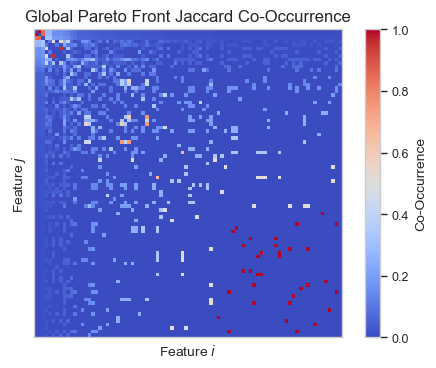

In [43]:
# Plot Global Pareto Front Jaccard Co-Occurrence heatmap
fig, ax = plt.subplots()
heatmap = ax.imshow(filtered_ordered_jaccard_matrix, cmap = "coolwarm", interpolation = "nearest")
fig.colorbar(heatmap, ax = ax, label = "Co-Occurrence")  # Add color scale

# Remove ticks and gridlines
ax.set_xticks([])
ax.set_yticks([])

# Add labels
ax.set_xlabel(r"Feature $i$")
ax.set_ylabel(r"Feature $j$")
ax.set_title("Global Pareto Front Jaccard Co-Occurrence")

plt.show()

In [44]:
print(f"High co-occurrence: {gene_name_list[95]} and {gene_name_list[114]} = {filtered_ordered_jaccard_matrix[5, 7]}")
print(f"High co-occurrence: {gene_name_list[3]} and {gene_name_list[55]} = {filtered_ordered_jaccard_matrix[24, 31]}")
print(f"High co-occurrence: {gene_name_list[3]} and {gene_name_list[92]} = {filtered_ordered_jaccard_matrix[26, 31]}")

High co-occurrence: JAK2 and CCND1 = 0.9565217391304348
High co-occurrence: E2F2 and PRLR = 0.75
High co-occurrence: E2F2 and YWHAZ = 0.75


### Global Pareto Fronts

In [45]:
def is_pareto_optimal(solutions):
    """
    Returns a boolean array indicating whether each point is Pareto optimal.
    Minimizing first column (features), maximizing second (accuracy).
    """
    num_solutions = solutions.shape[0]
    is_optimal = np.ones(num_solutions, dtype = bool)

    for i in range(num_solutions):
        for j in range(num_solutions):
            if i != j:
                # Check if point j dominates point i
                if (solutions[j, 0] <= solutions[i, 0] and solutions[j, 1] >= solutions[i, 1]) and \
                   (solutions[j, 0] < solutions[i, 0] or solutions[j, 1] > solutions[i, 1]):
                    is_optimal[i] = False
                    break  
    return is_optimal

# ----------
# LASSO-MO
# ----------

# Gather all 20 arrays into one
all_repeat_run_lasso_mo_results = []

for i in range(20):
    arr = repeat_run_lasso_mo_results[f"{i+1}"]["results"]["F"]
    x = arr[:, 0]
    y = np.abs(arr[:, 1])  # Convert to positive
    all_repeat_run_lasso_mo_results.extend(np.stack((x, y), axis = 1))

# Remove duplicates and compute Pareto front
all_repeat_run_lasso_mo_results = np.unique(np.array(all_repeat_run_lasso_mo_results), axis = 0)
optimal_mask = is_pareto_optimal(all_repeat_run_lasso_mo_results)
repeat_run_lasso_mo_global_pareto_front = all_repeat_run_lasso_mo_results[optimal_mask]

print("Global Pareto front across 20 sets:")
print(repeat_run_lasso_mo_global_pareto_front)

# Hypervolume calculation
repeat_run_lasso_mo_global_pareto_front_min = repeat_run_lasso_mo_global_pareto_front.copy()
repeat_run_lasso_mo_global_pareto_front_min[:, 1] *= -1
repeat_run_lasso_mo_hv = HV(ref_point = hv_reference_point)
repeat_run_lasso_mo_hypervolume = repeat_run_lasso_mo_hv.do(repeat_run_lasso_mo_global_pareto_front_min)
print(f"Hypervolume: {repeat_run_lasso_mo_hypervolume}")

# ----------------------
# VI mutation operator
# ----------------------

# Gather all 20 arrays into one
all_final_repeat_run_solutions = []

for i in range(20):
    arr = final_repeat_run_results[f"{i+1}"]["results"]["F"]
    x = arr[:, 0]
    y = np.abs(arr[:, 1])  # Convert to positive
    all_final_repeat_run_solutions.extend(np.stack((x, y), axis = 1))

# Remove duplicates and compute Pareto front
all_final_repeat_run_solutions = np.unique(np.array(all_final_repeat_run_solutions), axis = 0)
optimal_mask = is_pareto_optimal(all_final_repeat_run_solutions)
final_repeat_run_global_pareto_front = all_final_repeat_run_solutions[optimal_mask]

print("Global Pareto front across 20 sets:")
print(final_repeat_run_global_pareto_front)

# Hypervolume calculation
final_repeat_run_global_pareto_front_min = final_repeat_run_global_pareto_front.copy()
final_repeat_run_global_pareto_front_min[:, 1] *= -1
final_repeat_run_hv = HV(ref_point = hv_reference_point)
final_repeat_run_hypervolume = final_repeat_run_hv.do(final_repeat_run_global_pareto_front_min)
print(f"Hypervolume: {final_repeat_run_hypervolume}")

# ----------------------------
# Standard mutation operator
# ----------------------------

# Gather all 20 arrays into one
all_repeat_run_standard_mutation_operator_solutions = []

for i in range(20):
    arr = repeat_run_standard_mutation_operator_results[f"{i+1}"]["results"]["F"]
    x = arr[:, 0]
    y = np.abs(arr[:, 1])  # Convert to positive
    all_repeat_run_standard_mutation_operator_solutions.extend(np.stack((x, y), axis = 1))

# Remove duplicates and compute Pareto front
all_repeat_run_standard_mutation_operator_solutions = np.unique(np.array(all_repeat_run_standard_mutation_operator_solutions), axis = 0)
optimal_mask = is_pareto_optimal(all_repeat_run_standard_mutation_operator_solutions)
repeat_run_standard_mutation_operator_global_pareto_front = all_repeat_run_standard_mutation_operator_solutions[optimal_mask]

print("Global Pareto front across 20 sets:")
print(repeat_run_standard_mutation_operator_global_pareto_front)

# Hypervolume calculation
repeat_run_standard_mutation_operator_global_pareto_front_min = repeat_run_standard_mutation_operator_global_pareto_front.copy()
repeat_run_standard_mutation_operator_global_pareto_front_min[:, 1] *= -1
repeat_run_standard_mutation_operator_hv = HV(ref_point = hv_reference_point)
repeat_run_standard_mutation_operator_hypervolume = repeat_run_standard_mutation_operator_hv.do(repeat_run_standard_mutation_operator_global_pareto_front_min)
print(f"Hypervolume: {repeat_run_standard_mutation_operator_hypervolume}")

Global Pareto front across 20 sets:
[[  2.           0.25826142]
 [  3.           0.25916725]
 [  4.           0.25945588]
 [  5.           0.2607076 ]
 [  6.           0.26075735]
 [  7.           0.26102111]
 [  8.           0.26195181]
 [ 18.           0.26312139]
 [ 20.           0.26336028]
 [ 25.           0.26619831]
 [ 28.           0.26821645]
 [ 35.           0.26829859]
 [ 42.           0.2701984 ]
 [ 45.           0.270374  ]
 [ 47.           0.27099721]
 [ 50.           0.27158953]
 [ 55.           0.27198517]
 [ 56.           0.27246296]
 [ 58.           0.28272769]
 [ 66.           0.28474583]
 [ 72.           0.28723796]
 [ 80.           0.291018  ]
 [ 82.           0.29785992]
 [ 87.           0.30049524]
 [ 89.           0.30269121]
 [108.           0.3095866 ]
 [130.           0.31269219]
 [132.           0.32006535]
 [137.           0.32302551]
 [144.           0.32848002]
 [151.           0.33439876]
 [170.           0.33895878]
 [172.           0.35358835]]
Hyperv

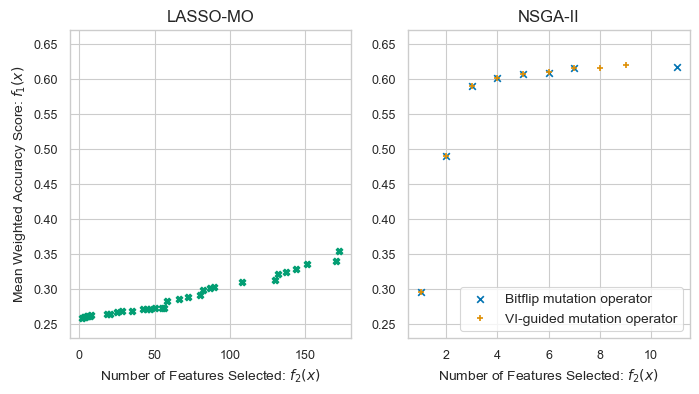

In [46]:
fig, axs = plt.subplots(1, 2, figsize = (8, 4))

# LASSO-MO
num_features_global_lasso_mo_repeats = repeat_run_lasso_mo_global_pareto_front[:, 0].tolist()
weighted_accuracy_global_lasso_mo_repeats = repeat_run_lasso_mo_global_pareto_front[:, 1].tolist()
weighted_accuracy_global_lasso_mo_repeats = [abs(acc) for acc in weighted_accuracy_global_lasso_mo_repeats] # Convert to positive values

axs[0].scatter(num_features_global_lasso_mo_repeats, weighted_accuracy_global_lasso_mo_repeats, 
           label = "LASSO-MO", marker = "X", color = "#029E73")

# Standard mutation operator
num_features_global_standard_mutation_operator_repeats = repeat_run_standard_mutation_operator_global_pareto_front[:, 0].tolist()
weighted_accuracy_global_standard_mutation_operator_repeats = repeat_run_standard_mutation_operator_global_pareto_front[:, 1].tolist()
weighted_accuracy_global_standard_mutation_operator_repeats = [abs(acc) for acc in weighted_accuracy_global_standard_mutation_operator_repeats] # Convert to positive values

axs[1].scatter(num_features_global_standard_mutation_operator_repeats, weighted_accuracy_global_standard_mutation_operator_repeats, 
              label = "Bitflip mutation operator", marker = "x")

# VI mutation operator
num_features_global_final_repeats = final_repeat_run_global_pareto_front[:, 0].tolist()
weighted_accuracy_global_final_repeats = final_repeat_run_global_pareto_front[:, 1].tolist()
weighted_accuracy_global_final_repeats = [abs(acc) for acc in weighted_accuracy_global_final_repeats] # Convert to positive values

axs[1].scatter(num_features_global_final_repeats, weighted_accuracy_global_final_repeats, 
              label = "VI-guided mutation operator", marker = "+")

# Add y axis limits
axs[0].set_ylim(0.23, 0.67)
axs[1].set_ylim(0.23, 0.67)

# Add axis labels
axs[0].set_xlabel(r"Number of Features Selected: $f_2(x)$")
axs[1].set_xlabel(r"Number of Features Selected: $f_2(x)$")
axs[0].set_ylabel(r"Mean Weighted Accuracy Score: $f_1(x)$")

# Add plot titles
axs[0].set_title("LASSO-MO")
axs[1].set_title("NSGA-II")

# Add legend
axs[1].legend(loc = "lower right", frameon = True, facecolor = "white")

fig.savefig("global pareto front comparison.png", dpi = 300)